# Training & Validation Dataset Creation

This code is utilized to create the training and validation data for a ML algorithm to identify portable free-fall penetrometer (PFFP) deployments. The user manually selects 3 distinct points:

1. **Moment of release into air.** This is shown as the moment where the measured deceleration begins to decrease
2. **Moment of impact with water.** This is shown where the pore pressure readings begin to increase.
3. **Moment of seabed impact.** This is the moment preceding a sharp increase in measured deceleration

The fourth point of interest, **End of penetration.**, is automatically found. This is generally identified as the moment where the deceleration crosses 1g following the peak deceleration. 

A visualization of these distinct regions within the PFFP deceleration profile is shown below (Stark et al 2016; https://cdnsciencepub.com/doi/10.1139/cgj-2016-0087):
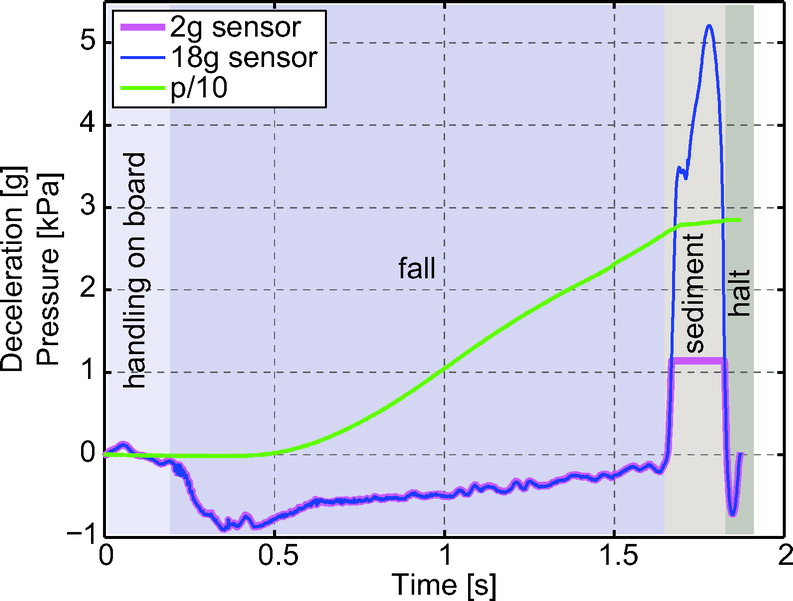

**Note:** *this code requires pop-ups of interactive images. Therefore, it will not run properly within the DesignSafe Jupyter Notebooks. It is recommended that this code be used in a local version of Juputer, such as that in Visual Studio Code.*


Import packages

In [8]:
import numpy
import numpy as np
import pandas as pd
import matplotlib
#%matplotlib ipympl
plt.rcParams["figure.dpi"] = 500
matplotlib.use('TkAgg') #the default is to have an image pop-out. Precede the image creation with the line above to embed within Jupyter
import matplotlib.pyplot as plt
from pathlib import Path

from scipy.signal import lfilter

User Inputs

In [4]:
# SETUP VARIABLES - USER INPUTS
dataset = "Sequim_2021"
BD = 3 #Bluedrop file is from 
fileNum = '034D' # write the bin file number you want to analyze (do not include 'bLog' or '.bin')
# paste the filepath to the folder where the BD data is stored
binFilepath = Path("C:/Users/elise/Desktop/Sequim_2021_Drops-Only")
#paste the filepath to an excel file that the analysis results will be printed in
outputPath = Path("C:/Users/elise/Desktop/ML Training Data/training_validation_master.xlsx") #  Path to pre-existing Excel File

Bring in and visualize data within the BlueDrop File

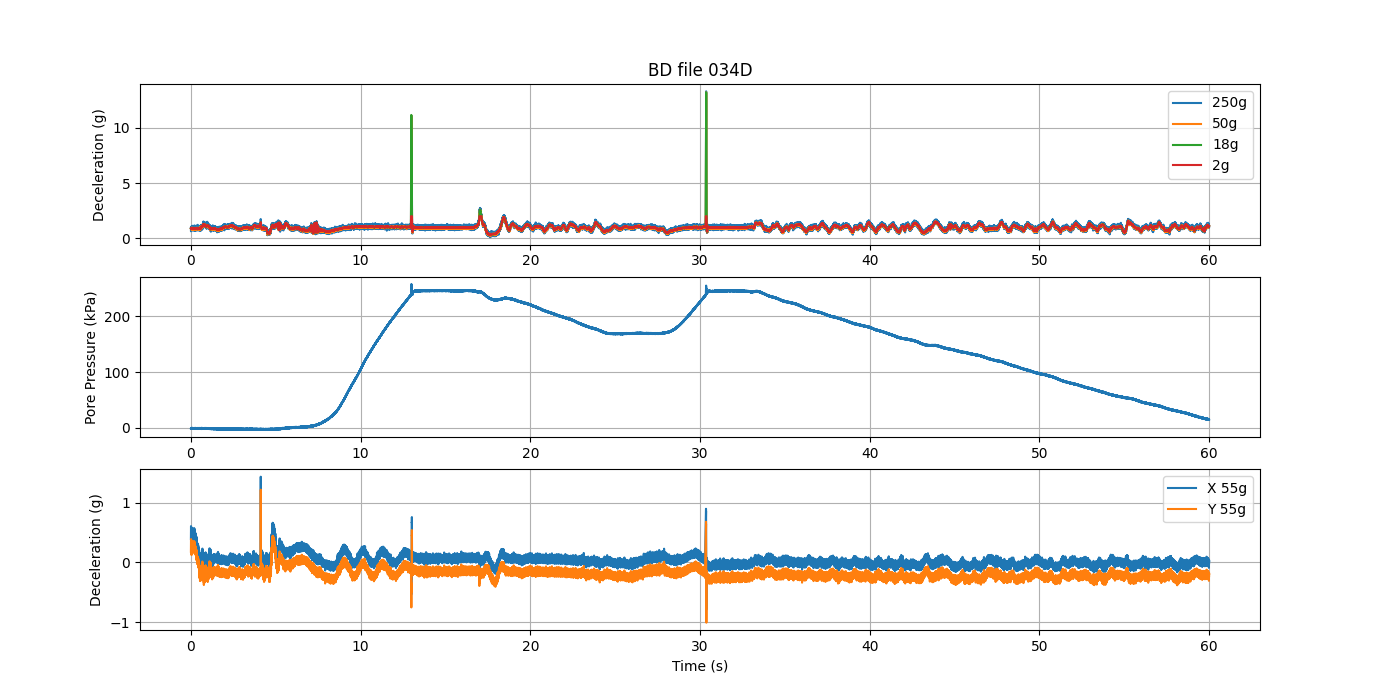

In [5]:
# READ BD DATA IN
data_array = []  # creates an empty array for us to fill with bd data
fileName = 'bLog'+fileNum+".bin"
# print(fileName)
newPath = binFilepath / fileName
#print(newPath)
file = open(newPath, 'rb')  # read file
element = file.read(3)  # create a byte list with each element having 3 bytes

while element:
    # Convert to signed integer before adding to data array
    iVAl = int.from_bytes(element, byteorder='big', signed=True)
    data_array.append(iVAl)  # adds the reshaped data from the bd file to the data frame
    element = file.read(3)

np_array = np.array(data_array)  # create numpy array from the list
np_array = np.reshape(np_array, (-1, 10))  # convert the 1d array to 2d array with 10 cols

#print(np_array.shape)
# print(np_array)

#Create uncalibrated dataframe from raw penetrometer readings
df = pd.DataFrame(np_array) # Creates a Dataframe in pandas from the bd data
df.columns = ['Count', 'no clue', 'g2g', 'g18g', 'g50g', 'ppm', 'g200g', 'gX55g', 'gY55g', 'g250g'] # names columns
# print(dfCal)

time = (df['Count']-df['Count'].iloc[0]+1)/2000 # gives time in s
count = df["Count"]-df['Count'].iloc[0]

#calibrate the dataframe
# APPLY CALIBRATION FACTORS
if BD == 3:  
    # calibration factors from March 2023
    '''g2g = (df['g2g']-33570.1)/1614577.9 #- offset# accelerometers are in g
    g18g = (df['g18g']+13495)/163387.2 #- offset
    g50g = (df['g50g']-238817.4)/63779.5 #- offset
    ppm = ((df['ppm']-139040.1)/20705) * 6.89475729 #converts to atm
    g200g = (df['g200g'] -262332.4)/38888.7 #- offset
    gX55g = (df['gX55g']-70406)/59754.3
    gY55g = (df['gY55g']-69421.1)/141871.5
    g250g = (df['g250g']-39077.4)/13746.9 #- offset'''
    # calibration factors for July 2019- March 2023:
    g2g=(df['g2g']-34426.5)/1615925.8 #accelerometers are in g
    g18g=(df['g18g']+12322.1)/163530.7
    g50g=(df['g50g']-237384.9)/63651-.1120
    ppm=((df['ppm']-62496.7)/20583.0) * 6.89475729 #converts to atm
    g200g=(df['g200g']-248943.7)/39009.4-.4878-.4832
    gX55g=(df['gX55g']-59093.7)/66674.3
    gY55g=(df['gX55g']-140224.6)/66674.3
    g250g=(df['g250g']-40536.1)/13631.6


if BD == 2: # calibration factors from March 2023
    g2g = (df['g2g']+36597.6)/1637627.3 #- offset# accelerometers are in g
    g18g = (df['g18g']-26185.3)/160297.2 #- offset
    g50g = (df['g50g']-212256.9)/63968.7 #- offset
    ppm = ((df['ppm']+55518.9)/18981.7) * 6.89475729 # converts to kPa
    g200g = (df['g200g']-175499.4)/30583.8 #- offset
    gX55g = (df['gX55g']-53629.9)/68590.9
    gY55g = (df['gY55g']-43694.3)/68280.3
    g250g = (df['g250g']-39619.9)/13545.8 #- offset

if BD == 1: # calibration factors from March 2023
    g2g = (df['g2g']-43727.6)/1625064 #- offset # accelerometers are in g
    g18g = (df['g18g']-45085.6)/160925.7 #- offset
    g50g = (df['g50g']-173493.4)/63944.6 #- offset
    ppm = ((df['ppm']+31776.1)/20679.7) * 6.89475729 # this is kPa
    g200g = (df['g200g'] -731734.3)/32192.4  #- offset
    gX55g = (df['gX55g'] -68837.9)/52137.3
    gY55g = (df['gY55g']-68015.9)/28074.9
    g250g = (df['g250g']+10580)/13688.7 #- offset

def overviewplot(): #Plot showing all accelerometers and pore pressure readings
    %matplotlib ipympl
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    fig.set_size_inches(14, 7)
    #plt.tight_layout()
    ax1.plot(time, g250g, label="250g")
    ax1.plot(time, g50g, label="50g")
    ax1.plot(time, g18g, label="18g")
    ax1.plot(time, g2g, label="2g")
    ax1.legend(loc = "upper right")
    ax1.set(ylabel="Deceleration (g)")
    ax1.set_title("BD file "+fileNum)
    ax1.grid()

    ax2.plot(time, ppm, label="Pore Pressure")
    ax2.set(ylabel="Pore Pressure (kPa)")
    ax2.grid()

    ax3.plot(time, gX55g, label="X 55g")
    ax3.plot(time, gY55g+1, label="Y 55g")
    ax3.legend(loc = "upper right")
    ax3.set(ylabel="Deceleration (g)")
    ax3.set(xlabel="Time (s)")
    ax3.grid()

    fig.subplots_adjust(bottom=.1, left = .1)
    plotName = fileNum+" Overview.png"
    #plt.savefig(plotPath / plotName)
    plt.show()

overviewplot()

Select which accelerometer should be used to pick the index points

In [6]:
def accPick(): #this function picks the smallest accelerometer that's not maxed out to perform the integration on
    maxAcc = g250g.max()
    print("Max Acceleration: ", maxAcc)
    global accNameg
    global accg
    if maxAcc < 5:
        if g2g.max() < 1.8: #offset:  # does an extra check for the 2g because of noise
            accg = g2g
            accNameg = "2g (g)"
        else:
            accg = g18g
            accNameg = "18g (g)"
    elif maxAcc < 18:
        accg = g18g
        accNameg = "18g (g)"
    elif maxAcc < 50:
        accg = g50g
        accNameg = "50g (g)"
    else:
        accg = g250g
        accNameg = "250g (g)"
    print("Accelerometer used: ", accNameg)


accPick()

Max Acceleration:  13.283246280700723
Accelerometer used:  18g (g)


Create a dataframe that only includes data from the relevant accelerometer and the pore pressure sensor

Dataframe with Pore Pressure and Accelerometer readings
              ppm   Acc (g)
0       -0.768998  0.916874
1       -0.253809  0.917767
2       -0.907342  0.918733
3       -1.550491  0.921522
4       -1.083873  0.917816
...           ...       ...
119995  15.463142  1.097776
119996  15.316089  1.097458
119997  15.018297  1.099060
119998  15.016288  1.106936
119999  15.142908  1.107077

[120000 rows x 2 columns]


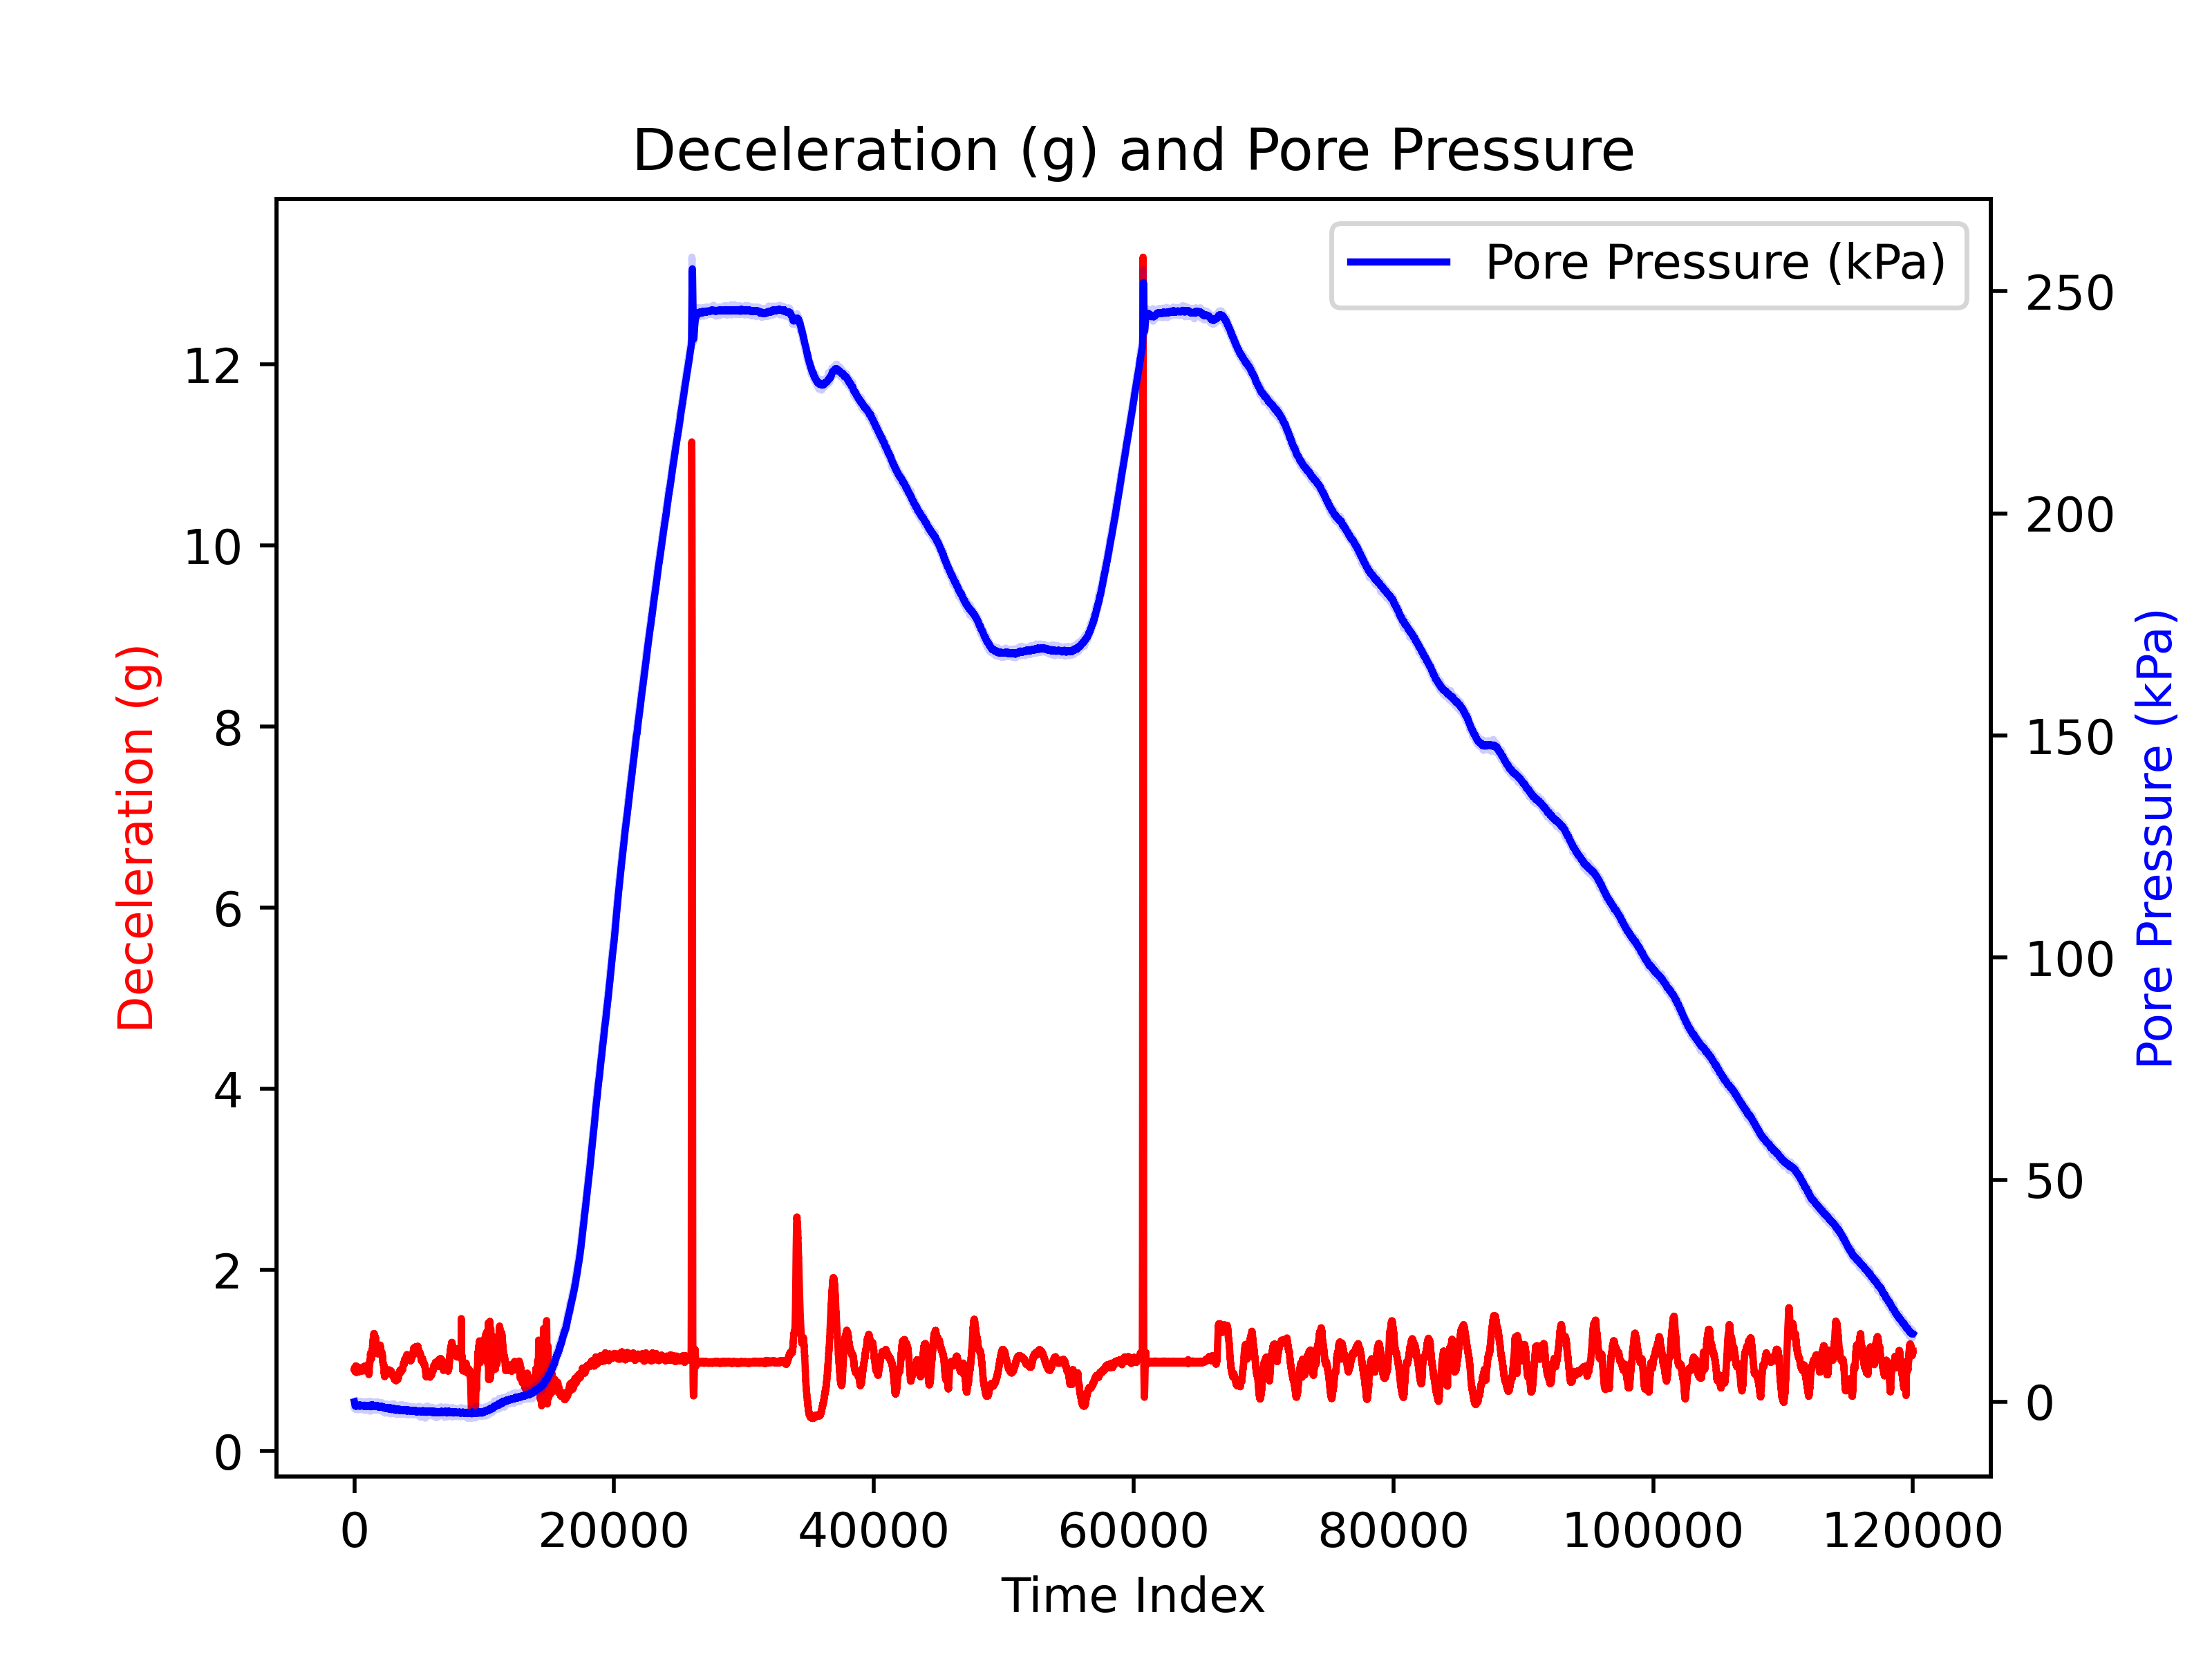

In [9]:
#print(accg)
#print(count)

d = {'ppm': ppm, 'Acc (g)': accg}
data = pd.DataFrame(data=d)

#data = np.array([time], [accg])  # Example data
print("Dataframe with Pore Pressure and Accelerometer readings")
print(data)
#data = pd.DataFrame(data)
#print(data)

#Plot the relevant data
def plot_interactive_sample():
    %matplotlib ipympl
    fig, (ax1) = plt.subplots(1)
    ax1.plot(accg, color = 'r', label = "Deceleration (g)")
    plt.title("Deceleration (g) and Pore Pressure")
    ax1.set_ylabel("Deceleration (g)", color = 'r')
    ax1.set(xlabel="Time Index")
    
    ax2 = ax1.twinx()

    #filter the pore pressure readings to show a smoother line
    c=1
    n = 50  # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    ppm_filtered = lfilter(b, c, ppm)

    #Plot pore pressure
    ax2.plot(ppm, color = 'b', alpha = .2)
    ax2.plot(ppm_filtered, color = 'b', label = "Pore Pressure (kPa)")
    ax2.set_ylabel("Pore Pressure (kPa)", color = 'b')
    plt.legend(loc = "upper right")

    #below works well for sands but not clays
    '''plt.plot(data, label = ("Pore Pressure (kPa)", "Deceleration (g)"))
    plt.title("Deceleration (g) and Pore Pressure")
    plt.xlabel("Count")
    plt.ylabel("Deceleration (g)")
    plt.legend()
    plt.grid(True)
    #plt.show()'''

plot_interactive_sample()

Select the approximate peak deceleration for each drop

In [206]:
matplotlib.use('TkAgg')

def peak_pick():
    fig, (ax1) = plt.subplots(1)
    ax1.plot(accg, color = 'r', label = "Deceleration (g)")
    plt.title("Select Drops (Enter to Exit)")
    ax1.set_ylabel("Deceleration (g)", color = 'r')
    ax1.set(xlabel="Time Index")
    
    ax2 = ax1.twinx()

    #filter the pore pressure readings to show a smoother line
    c=1
    n = 50  # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    ppm_filtered = lfilter(b, c, ppm)

    #Plot pore pressure
    ax2.plot(ppm, color = 'b', alpha = .2)
    ax2.plot(ppm_filtered, color = 'b', label = "Pore Pressure (kPa)")
    ax2.set_ylabel("Pore Pressure (kPa)", color = 'b')

    '''plt.plot(data)
    plt.title("Select Drops (Enter to Exit)")
    plt.xlabel("Count")
    plt.ylabel("Deceleration (g)")
    #plt.legend("Deceleration (g)", "Pore Pressure (kPa)")'''

    plt.grid(True)
    #plt.show()
    global approx_peak_index_list
    global num_drops

    peak_approx_list = []

    peak_approx = plt.ginput(n=-1, show_clicks=True)
    for t in peak_approx:
        for x in t:
            peak_approx_list.append(x)
    #user_input = input("Enter a value (press Enter to stop): ")
    plt.close()
    num_drops = int(len(peak_approx_list)/2)
    print(num_drops, "drops in file")

    approx_peak_index_list = peak_approx_list[::2]
    for a in range(0,len(approx_peak_index_list)):
        approx_peak_index_list[a] = int(approx_peak_index_list[a])
    print("Coordinates of Approximate peaks (index, acceleration):", peak_approx_list)
    print("Approx Peak Indexes:", approx_peak_index_list) 

peak_pick()

2 drops in file
Coordinates of Approximate peaks (index, acceleration): [25935.267741935488, 216.61415089948832, 60425.30290322581, 257.7021639958839]
Approx Peak Indexes: [25935, 60425]


Select range for plots

In [207]:
plot_start_list = []
plot_end_list = [] 
index_list = []
for a in range(0, num_drops):
    peak = approx_peak_index_list[a]
    if peak <= 20000:
        plotstart = 1
        plotend = peak + 1000
        
    elif peak > 119500:
        plotstart = peak - 20000
        plotend = 120000
    else:
        plotstart = peak - 20000
        plotend = peak + 1000
    plot_start_list.append(plotstart)
    plot_end_list.append(plotend)
    index_list.append(a+1)
plot_ranges = {'Start':plot_start_list, "End":plot_end_list}
plot_range_df = pd.DataFrame(data=plot_ranges, index = index_list)
print(plot_range_df)

   Start    End
1   5935  26935
2  40425  61425


Refine peak picks to be maximum deceleration in the interval defined above

[11.145846620848562, 13.187041332300296]
25975
60725
[25975, 60725]
         acc  index
0  11.145847  25975
1  13.187041  60725


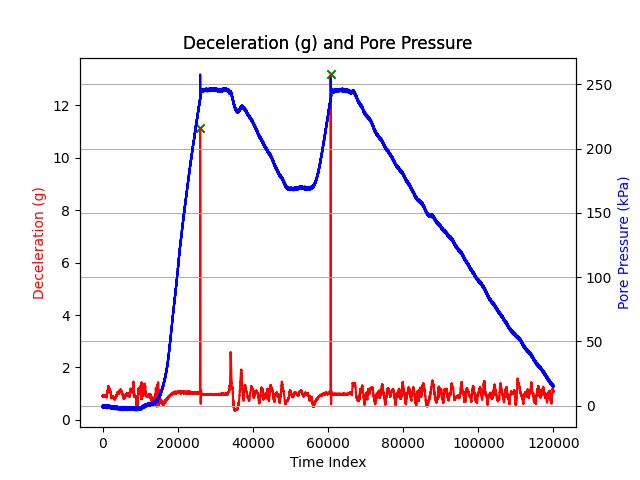

In [208]:
#finds the actual maximum deceleration (not just the approximated one)
#print(plot_range_df.at[1,'Start'])
max_dec_list = []
for a in range(1, num_drops+1):
    max_dec = max(accg[plot_range_df.at[a,'Start']:plot_range_df.at[a,'End']])
    max_dec_list.append(max_dec)
    #print(max_dec) #these should match the maximum values shown in cell []
print(max_dec_list)

#makes a dataframe of only deceleration values
index_df = pd.DataFrame(data={'Accg':accg}, index = range(0,len(accg)))
#print(index_df)

max_index_list = []
#finds the index of the maximum deceleration values
for a in range(1, num_drops+1):
    drop_range = index_df[plot_range_df.at[a,'Start']:plot_range_df.at[a,'End']]
    #print(drop_range)
    max_index = drop_range.idxmax().values
    max_index = int(max_index)
    max_index_list.append(max_index)
    print(max_index)
print(max_index_list)

#visualize the above points for validation
relevant_pts = pd.DataFrame({"acc":max_dec_list, "index":max_index_list})
print(relevant_pts)

%matplotlib ipympl

fig, (ax1) = plt.subplots(1)
ax1.plot(accg, color = 'r', label = "Deceleration (g)")
plt.title("Deceleration (g) and Pore Pressure")
ax1.set_ylabel("Deceleration (g)", color = 'r')
ax1.set(xlabel="Time Index")
    
ax2 = ax1.twinx()



#Plot pore pressure
ax2.plot(ppm, color = 'b', label = "Pore Pressure (kPa)")
ax2.set_ylabel("Pore Pressure (kPa)", color = 'b')

#plt.plot(data, label = ("Deceleration (g)", "Pore Pressure ([])"))
ax1.scatter(relevant_pts[relevant_pts.columns[1]], relevant_pts[relevant_pts.columns[0]], marker = "x", color = "green", label = "Peaks")
plt.title("Deceleration (g) and Pore Pressure")
plt.xlabel("Count")
#plt.ylabel("Deceleration (g)")
plt.grid(True)
plt.show()

Define the plot that overlays deceleration and ppm

In [209]:
%matplotlib ipympl

def dec_ppm_plot():
    #Plot deceleration
    #fig, (ax1) = plt.subplots(1)
    ax1.plot(accg, color = 'r', label = "Deceleration (g)")
    ax1.set_xlim(left=plot_range_df.loc[a+1,'Start'], right=plot_range_df.loc[a+1,'End'])
    plt.title("Drop "+ str(a+1))
    ax1.set_ylabel("Deceleration (g)", color = 'r')
    ax1.set(xlabel="Time Index")
    plt.legend(loc = "upper left")
    ax2 = ax1.twinx()

    #filter the pore pressure readings to show a smoother line
    c=1
    n = 50  # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    ppm_filtered = lfilter(b, c, ppm)

    #Plot pore pressure
    ax2.plot(ppm, color = 'b', alpha = .2)
    ax2.plot(ppm_filtered, color = 'b', label = "Pore Pressure (kPa)")
    ax2.set_xlim(left=plot_range_df.loc[a+1,'Start'], right=plot_range_df.loc[a+1,'End'])
    ax2.set_ylabel("Pore Pressure (kPa)", color = 'b')
    plt.legend(loc = "upper right")
    

Preview the plots for interval picking

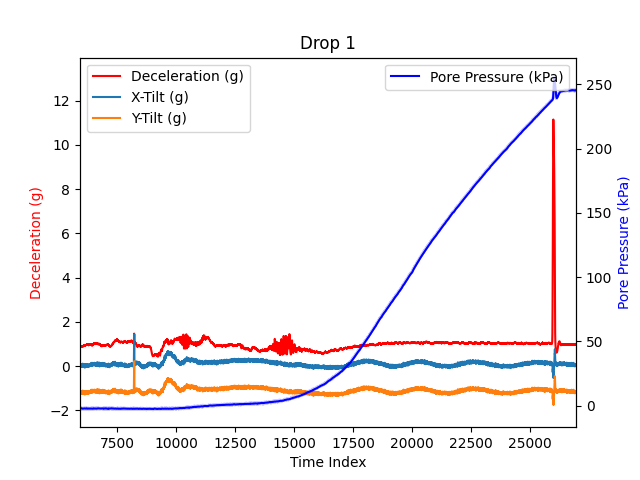

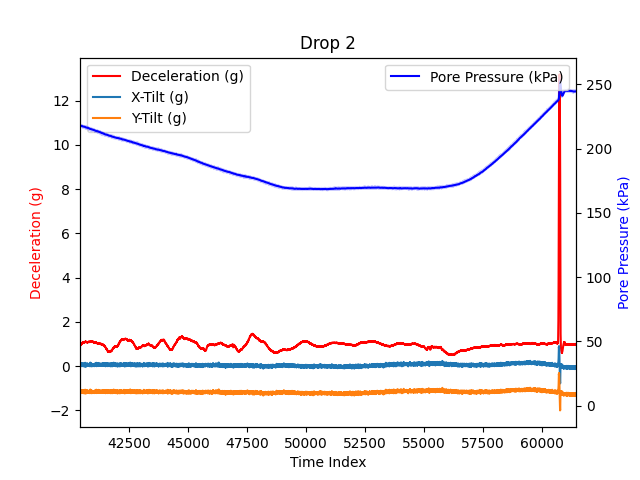

In [210]:
for a in range(0, num_drops):
    fig, (ax1) = plt.subplots(1)
    dec_ppm_plot()
    ax1.plot(gX55g, label = "X-Tilt (g)")
    ax1.plot(gY55g, label = "Y-Tilt (g)")
    ax1.legend(loc = "upper left")
    plt.show()

Create Array for indexing info to go into

In [211]:
# Create an empty DataFrame with 8 columns and n rows
#first 3 columns are filled in automatically using user inputs
#last column is a "toss-out" indicator, describing whether penetrometer likely fell over during penetration (1 = toss, 0 = keep)
#all other columns represent time index values

index_df = pd.DataFrame(columns=['file_num','dataset','drop_num', 'release', 'water_entry', 'sebed_pen', 'peak_dec', 'pen_end', "expert_req"], index=range(num_drops))

# Display the empty DataFrame
print(index_df)

  file_num dataset drop_num release water_entry sebed_pen peak_dec pen_end  \
0      NaN     NaN      NaN     NaN         NaN       NaN      NaN     NaN   
1      NaN     NaN      NaN     NaN         NaN       NaN      NaN     NaN   

  expert_req  
0        NaN  
1        NaN  


Find Point of penetration end (where values crosses 1g)

In [212]:
pen_end_list = []
for a in range(0, num_drops):
    global pen_end
    below0list = list()
    #for i in range(dropstart+jindex, dropend, 1):
    for i in range(relevant_pts.loc[a,"index"], plot_range_df.loc[a+1,'End']):
        if accg[i] < 1: #the offset is applied later in the code
            penend = i 
            below0list = np.append(below0list, penend)
    pen_end=int(min(below0list))
    pen_end_list.append(pen_end)

print(pen_end_list)

#add list to output dataframe
index_df['pen_end']= pen_end_list

[26064, 60782]


Decide if drop fell over during penetration

In [213]:
expert_req_list = []

keep_limit = 100 #maybe this should change?

for a in range(0, num_drops):

    if relevant_pts.loc[a,"index"] - pen_end_list[a] < keep_limit:
        expert_req = 0
    else:
        expert_req = 1

    expert_req_list.append(expert_req)

print(expert_req_list)

#add list to output dataframe
index_df['expert_req']= expert_req_list


[0, 0]


For each drop, pick index points for:
1. release
2. water entry, and 
3. pentration start 


In [214]:
matplotlib.use('TkAgg')
index_click_list = []

for a in range(0, num_drops):
    fig, (ax1) = plt.subplots(1)
    plt.title("Pick moments of release, water entry, and sebed penetration for drop "+ str(a+1))
    dec_ppm_plot()
    #specifies user inputs
    index_click = plt.ginput(n=-1, show_clicks=True)
    for t in index_click:
        for x in t:
            index_click_list.append(x)
    #user_input = input("Enter a value (press Enter to stop): ")
    plt.close()

#print(index_click_list)

#remove the axis values to only record the indices
index_click_list = index_click_list[::2]

print(index_click_list)

#convert to list of integers
for x in range(0, len(index_click_list)):
    index_click_list[x] = int(index_click_list[x])

print(index_click_list)


: 

Fill dataframe

In [199]:
# the expert_req and pen_end fields are already filled

# Define a function to copy every 4 inputs into a row of the DataFrame
def copy_inputs_to_dataframe(index_click_list, index_df):
    a = 0
    for i in range(0, len(index_click_list), 3):
        input_chunk = index_click_list[i:i+3]
        #print(input_chunk)
        #print(input_chunk[0])
        if len(input_chunk) == 3:
            index_df.at[a,"release"] = input_chunk[0]
            index_df.at[a,"water_entry"] = input_chunk[1]
            index_df.at[a,"sebed_pen"] = input_chunk[2]
        a = a+1
        
# Call the function to copy inputs into the DataFrame
copy_inputs_to_dataframe(index_click_list, index_df)

index_df['file_num']= fileNum
index_df['dataset']= dataset
index_df['expert_req']= expert_req_list
index_df["drop_num"] = range(1,num_drops+1)
index_df['peak_dec'] = relevant_pts["index"]
print(index_df)



  file_num      dataset  drop_num release water_entry sebed_pen  peak_dec  \
0     034B  Sequim_2021         1       9           9       442       488   

   pen_end  expert_req  
0      542           0  


Export data to master excel sheet

In [200]:
import pandas as pd

# Define the data to be added

# Create a DataFrame with the new data
new_data = index_df

# Load the existing Excel file (if it exists)
try:
    existing_data = pd.read_excel(outputPath)
    # Append the new data to the existing data
    updated_data = existing_data.append(new_data, ignore_index=True)
except FileNotFoundError:
    # If the file doesn't exist, create a new one with the new data
    updated_data = new_data

# Save the updated data to the Excel file
updated_data.to_excel(outputPath, index=False)

print("Data added successfully to training_validation_master.xlsx")


Data added successfully to training_validation_master.xlsx


C:\Users\elise\AppData\Local\Temp\ipykernel_5552\3808652148.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_data = existing_data.append(new_data, ignore_index=True)


## Variable Index

* **accPick()**: this function picks the smallest accelerometer that's not maxed out to perform the integration on
* **accNameg** : a string representing the name of the accelerometer used in the analysis
* **accg** : the accelerometer data used in the analysis (units of g)

* **BD** = bluedrop serial number (works for 1, 2, 3; used to calibrate)
* **binFilepath** = path to location bin file is stored
* **dataset** = dataset data is from (eg. Arolik_2023)
* **fileNum** = bin file number you want to analyze (do not include 'bLog' or '.bin')
* **outputPath** =  path to excel sheet that will store the data

* **data_array** = 2d array with 10 cols to hold raw BD data
* **fileName** = 'bLog'+fileNum+".bin"
* **newPath** = binFilepath / fileName
* **file** = open(newPath, 'rb')  # read file
* **element** = file.read(3)  # create a byte list with each element having 3 bytes

* **df** a Dataframe in pandas from the bd data with columns ['Count', 'no clue', 'g2g', 'g18g', 'g50g', 'ppm', 'g200g', 'gX55g', 'gY55g', 'g250g'] 

* **time** = gives time in s
* **count** = time in ms, used for indexing time

* **g2g** = calibrated values from 2g accelerometer in g
* **g18g** = calibrated values from 18g accelerometer in g
* **g50g** = calibrated values from 50g accelerometer in g
* **ppm** = ((df['ppm']-139040.1)/20705) * 6.89475729 #converts to atm
* **g200g** = calibrated values from 200g accelerometer in g
* **gX55g** = calibrated values from X55g accelerometer in g
* **gY55g** = calibrated values from Y55g accelerometer in g
* **g250g** = calibrated values from 250g accelerometer in g

* **overviewplot** = Plot showing all accelerometers and pore pressure readings

* **d** = array with pore pressure and acceleration data
* **data** = dataframe of pore pressure and acceleration data

* **plot_interactive_sample()** plot of deceleration and pore pressure vs count

* **peak_pick()** = interactive plot used to pick approximate locations of drops (ie max deceleration)
* **peak_approx_list** = list of the index and deceleration values of the selected approximate peaks
* **peak_approx** = plt.ginput function used to select approximate peaks(n=-1, show_clicks=True)
* **num_drops** = number of drops in the file, determined by the number of peaks selected in peak_pick()
* **approx_peak_index_list** = list of the index values selected in peak pick()

* **plot_start_list** list of the index 1500 counts before the approximate peak for each drop in the file
* **plot_end_list** = list of the index 500 counts after the approximate peak for each drop in the file
* **index_list** = list of the drop index
* **plot_ranges** = array of plot starts and plot ends
* **plot_range_df** = dataframe of  plot starts and plot ends with index values defined in the index list


* **max_dec_list** = list of the maximum deceleration values (not approximated by peak clicking)
* **max_dec** = maximum deceleration value added to max_dec_list  
* **index_df** = a dataframe of only deceleration values
* **max_index_list** = list of the count index of the max_dec values
* **max_index** = count index of the max_dec values added to max_index_list
* **relevant_pts** = dataframe of peak accelerations and their associated count index 

* ***dec_ppm_plot()** = function for creation of plot of deceleration and pore pressure to be used in index picking

* **index_df** = dataframe for index values to go into with columns 'file_num','dataset','drop_num', 'release', 'water_entry', 'sebed_pen', 'peak_dec', 'pen_end', "expert_req"

* **pen_end_list** = list of index values where deceration crosses 1g
* **below_0_list** = list of all values after the peak deceleration with acceleration values less than 1g
* **pen_end** = first index after peak with acceleration value less than 1g

* **expert_req_list** = list of whether or not an expert should look at each drop in the file (0 = no, 1 = yes)
* **expert_req** = a 0 or 1 representing whether an expert should look at a specific drop
* **keep_limit** = maxium number of counts between max deceleration and penetration end value that is allowed before saying an expert is required

* **index_click** = ginput function for the release, water entry, and seabed impact points
* **index_click_list** = list of the count index for the release, water entry, and seabed impact points for each drop in the file

* **copy_inputs_to_dataframe(index_click_list, index_df)** = function that copies count index for the release, water entry, and seabed impact points for each drop in the file into the index_df
* **input_chunk** = all values of release index, water entry index or impact indexes





